In [1]:
import pandas as pd
import numpy as np
from random import sample
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, \
recall_score, accuracy_score, precision_score, confusion_matrix, f1_score
import seaborn as sns
from catboost import CatBoostClassifier

In [2]:
df_train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')
df_train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID')

In [3]:
df_train_identity.shape

(144233, 40)

In [4]:
df_train_transaction.shape

(590540, 393)

# Merge transaction and identity dataset

In [5]:
df_train = pd.merge(
    df_train_identity, df_train_transaction, how='left', on='TransactionID')

In [6]:
df_train.shape

(144233, 433)

# Imbalanced random sample

In [ ]:
df_train = df_train.sample(n = 22636, random_state=1)

In [ ]:
df_train['isFraud'].value_counts()

# Balance the dataset

In [7]:
mask = df_train['isFraud'] == 1

train_fraud = df_train[mask]
train_non = df_train[-mask]

train_not = train_non.sample(n = int(len(train_fraud)), random_state=1)

df_train_balanced = pd.concat([train_fraud, train_not])

print (len(train_fraud))
print (len(train_not))
print (len(df_train_balanced))

11318
11318
22636


In [8]:
df_train = df_train.iloc[0:0]
df_train = df_train_balanced.copy()
df_train

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987240,0.0,169947.0,0.0,0.0,3.0,0.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987243,0.0,222455.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987245,0.0,271870.0,0.0,0.0,3.0,0.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987288,-20.0,258138.0,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987367,-5.0,141271.0,NaN,NaN,9.0,-81.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111954,-5.0,59099.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3103608,-5.0,110880.0,NaN,NaN,15.0,-48.0,NaN,NaN,NaN,NaN,...,1.0,0.0,2000.0,2000.0,0.0,0.0,0.0,0.0,500.0,500.0
3542667,-5.0,307190.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Bit of Preprocessing and Sanity Check

#### card6: type of card; we drop the 3 unique rows of 'debit or credit' and 'charge card'

In [9]:
mask = df_train['card6'] != 'debit or credit'
df_train = df_train[mask]
mask2 = df_train['card6'] != 'charge card'
df_train = df_train[mask2]

In [10]:
# drop target column
target = df_train['isFraud'].copy()
df_train = df_train.drop('isFraud', axis=1)

# V columns correlated with each other so we filter

In [11]:
V_list = []
for i in range(93, 432):
    V_list.append(df_train.columns[i])

In [12]:
corr_matrix = df_train[V_list].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_train = df_train.drop(df_train[to_drop], axis=1)

In [ ]:
df_train

#### transformation pipeline

#### MinMaxScale our numeric features

#### OneHotEncode our categoric features

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
class OneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self,col):
        self.col = col
                
    def transform(self, X):
        return pd.get_dummies(X[self.col]) 

    def fit(self, X, y=None):
        return self  
    
# Transformer that does min-max transform on the specified columns
class MinMaxTransform(BaseEstimator, TransformerMixin):

    def __init__(self,cols=None):
        self.cols = cols
        self.minVec = np.zeros(len(cols))
        self.maxVec = np.zeros(len(cols))
       
    def transform(self, X):
        X[self.cols] = ((X[self.cols] - self.minVec)/(self.maxVec-self.minVec))
        return X

    def fit(self, X, y=None):
        self.minVec = (df_train[self.cols].min())
        self.maxVec = (df_train[self.cols].max())
        return self

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
numeric_features = df_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(
    steps=[('minmax', MinMaxTransform(numeric_features))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

In [ ]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# numeric_features = df_train.select_dtypes(include=['int64', 'float64']).columns
# # categorical_features = df_train.select_dtypes(include=['object']).columns

# numeric_transformer = Pipeline(
#     steps=[('minmax', MinMaxTransform(numeric_features))])
# categorical_transformer = Pipeline(
#     steps=[('onehot', OneHotEncoder(categorical_features))])

# preprocessor = ColumnTransformer(
#     transformers=[('num', numeric_transformer, numeric_features),
#                   ('cat', categorical_transformer, categorical_features)])

# Fill NaNs with -999 to avoid overfitting on NaN

In [ ]:
for col in df_train:
    df_train[col].fillna(-999, inplace=True)

# Convert categorical features to integers

In [15]:
cat_index = np.where(df_train.dtypes != np.float)[0]
for i in cat_index:
    df_train[df_train.columns[i]] = df_train[df_train.columns[i]].astype('category').cat.codes

In [16]:
pd.set_option('display.max_rows', 300)
df_train.dtypes

id_01             float64
id_02             float64
id_03             float64
id_04             float64
id_05             float64
id_06             float64
id_07             float64
id_08             float64
id_09             float64
id_10             float64
id_11             float64
id_12                int8
id_13             float64
id_14             float64
id_15                int8
id_16                int8
id_17             float64
id_18             float64
id_19             float64
id_20             float64
id_21             float64
id_22             float64
id_23                int8
id_24             float64
id_25             float64
id_26             float64
id_27                int8
id_28                int8
id_29                int8
id_30                int8
id_31                int8
id_32             float64
id_33                int8
id_34                int8
id_35                int8
id_36                int8
id_37                int8
id_38                int8
DeviceType  

# CatBoost

In [17]:
x_train, x_val, target_train, target_val = train_test_split(
    df_train, target, test_size=0.2, random_state=1)
categorical_features_indices = np.where(df_train.dtypes != np.float)[0]
clf = CatBoostClassifier(random_seed=1, eval_metric='AUC:hints=skip_train~false', silent=True)
clf.fit(
    x_train, target_train, cat_features=categorical_features_indices,
    use_best_model=True, eval_set=(x_val, target_val))

In [18]:
target_probs = clf.predict_proba(x_val)
target_preds = target_probs[:,1]
fpr, tpr, threshold = roc_curve(target_val, target_preds)
print('CatBoost AUC score:', auc(fpr, tpr))

CatBoost AUC score: 0.9771632034222981


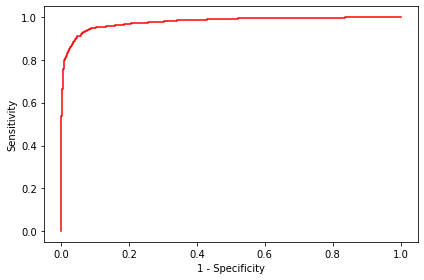

In [19]:
plt.figure()
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.plot(fpr, tpr, 'r', markersize = 2)
plt.tight_layout()
plt.show()

In [20]:
pd.set_option('display.max_rows', 300)
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,C1,9.175728
1,card1,7.487429
2,C14,5.990616
3,TransactionAmt,4.811421
4,DeviceInfo,4.401840
5,R_emaildomain,3.500860
6,id_31,3.451118
7,id_20,2.530915
8,C13,2.447900
9,id_02,2.211529
